In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from statsmodels.tsa.seasonal import MSTL, DecomposeResult
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

In [2]:
# ============ loading data =================
df = pd.read_parquet("../data/processed/bordeaux_conso_mwh.parquet")
df.head()

,date,daily_conso_mgw
0,2022-01-01,1153665
1,2022-01-02,1194663
2,2022-01-03,1391133
3,2022-01-04,1432283
4,2022-01-05,1555351


In [3]:
# ========== first checking =============
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431 entries, 0 to 1430
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1431 non-null   datetime64[ns]
 1   daily_conso_mgw  1431 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 22.5 KB


In [4]:
# ========== checking missing values ==============
df.isnull().sum()

date               0
daily_conso_mgw    0
dtype: int64

In [5]:
# ============ Checking duplicates values ============= 
df.duplicated().sum()

np.int64(0)

In [6]:
df.describe()

,date,daily_conso_mgw
count,1431,1.431000e+03
mean,2023-12-17 00:00:10.062893056,1.166662e+06
min,2022-01-01 00:00:00,1.752760e+05
25%,2022-12-24 12:00:00,1.020350e+06
50%,2023-12-17 00:00:00,1.099413e+06
75%,2024-12-08 12:00:00,1.318330e+06
max,2025-12-01 00:00:00,1.807858e+06
std,NaN,2.167462e+05


# Eda 

In [7]:
fig = px.line(
    df, 
    x="date", 
    y='daily_conso_mgw', 
    title="Consmmation journalière (MWG) sur Bordeaux", 
    labels={'date': 'Date', 'daily_conso_mgw': 'Consommation (MWg)'}
)

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Consommation (MWg)',
    template='plotly_white'
)

fig.show()

<Figure size 1200x500 with 0 Axes>

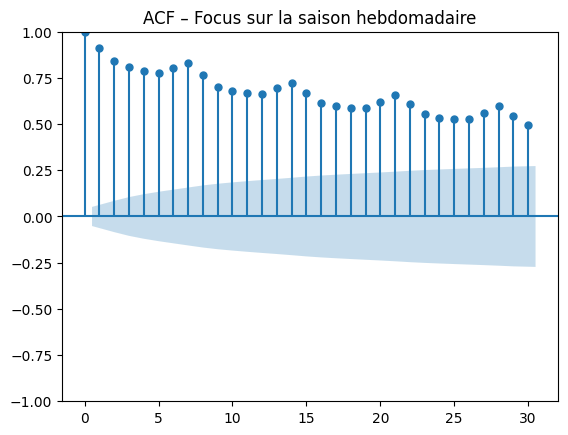

In [8]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(12,5))
plot_acf(df['daily_conso_mgw'], lags=30)  # on se concentre sur la saison hebdo
plt.title("ACF – Focus sur la saison hebdomadaire")
plt.show()

In [9]:
from statsmodels.tsa.stattools import acf
import numpy as np

series = df['daily_conso_mgw']

acf_values = acf(series, nlags=400)

print("ACF lag 7 :", acf_values[7])
print("ACF lag 30 :", acf_values[30])  # éventuellement mensuelle faible
print("ACF lag 365 :", acf_values[365] if len(acf_values) > 365 else "Pas assez d'observations")

crit = 2 / np.sqrt(len(series))
print(f"\nSeuil significatif ≈ {crit:.4f}")

# Interprétation
if abs(acf_values[7]) > crit:
    print("➡️ Saison hebdomadaire significative ✔️")
else:
    print("➡️ Saison hebdomadaire faible ou absente ❌")

if len(acf_values) > 365 and abs(acf_values[365]) > crit:
    print("➡️ Saison annuelle significative ✔️")
else:
    print("➡️ Pas de saison annuelle détectée ou échantillon insuffisant ❌")

ACF lag 7 : 0.8282550887517057
ACF lag 30 : 0.4934422718671003
ACF lag 365 : 0.5492256784586727

Seuil significatif ≈ 0.0529
➡️ Saison hebdomadaire significative ✔️
➡️ Saison annuelle significative ✔️


In [10]:
mstl = MSTL(df['daily_conso_mgw'], periods=[7, 365])
res = mstl.fit()

df['trend'] = res.trend
df['seasonal_7'] = res.seasonal['seasonal_7']
df['seasonal_365'] = res.seasonal['seasonal_365']
df['resid'] = res.resid

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['daily_conso_mgw'], mode='lines', name='Original'))
fig.add_trace(go.Scatter(x=df.index, y=df['trend'], mode='lines', name='Trend'))
fig.add_trace(go.Scatter(x=df.index, y=df['seasonal_7'], mode='lines', name='Seasonal Hebdo'))
fig.add_trace(go.Scatter(x=df.index, y=df['seasonal_365'], mode='lines', name='Seasonal Annuel'))

fig.update_layout(title='Décomposition MSTL de la consommation journalière',
                  xaxis_title='Date',
                  yaxis_title='Consommation (MWg)',
                  template='plotly_white')
fig.show()

# Résidus
fig_resid = go.Figure()
fig_resid.add_trace(go.Scatter(x=df.index, y=df['resid'], mode='markers', name='Résidus'))
fig_resid.update_layout(title='Résidus MSTL (outliers possibles)',
                        xaxis_title='Date',
                        yaxis_title='Résidus',
                        template='plotly_white')
fig_resid.show()

In [11]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Test Ljung-Box sur les résidus
residus = df['resid'].dropna()
lb_test = acorr_ljungbox(residus, lags=[10, 20, 30], return_df=True)
print(lb_test)

        lb_stat  lb_pvalue
10  2611.683243        0.0
20  2658.239220        0.0
30  2725.922015        0.0


# 📊 Analyse exploratoire et multi-saisonnalité de la consommation journalière

---

## 1️⃣ Analyse descriptive

- La série contient **1431 jours**, du 01/01/2022 au 01/12/2025.  
- Aucune valeur manquante, ce qui est idéal pour l’analyse temporelle.  
- Statistiques principales de la consommation journalière (`daily_conso_mgw`) :

| Statistique | Valeur |
|------------|--------|
| Min        | 175 276 |
| 25%        | 1 020 350 |
| Médiane    | 1 099 413 |
| Moyenne    | 1 166 662 |
| 75%        | 1 318 330 |
| Max        | 1 807 858 |
| Écart-type | 216 746 |

**Interprétation :**  
- La consommation varie fortement d’un jour à l’autre, avec quelques **pics exceptionnels**.  
- La majorité des jours se situe autour de **1 à 1,3 M MWg**.  
- Cette variabilité justifie de **séparer trend, saisonnalités et résidus** pour mieux comprendre la série.

---

## 2️⃣ Analyse graphique

- **Multi-saisonnalité visible** :  
  - Saisonnalité hebdomadaire (week-end vs semaine)  
  - Saisonnalité annuelle (été vs hiver)  

- **Outliers ponctuels** : quelques valeurs extrêmes apparaissent, probablement liées à des événements exceptionnels.  

- **Trend** : aucun trend clair n’est visible à l’œil nu ; la tendance semble **quasi horizontale**.  

💡 Remarque : pour analyser le trend et séparer les composantes saisonnières, une **décomposition MSTL ou un modèle TBATS/Prophet** sera nécessaire.

---

## 3️⃣ Analyse des saisons via ACF

- **Lag 7 (hebdomadaire)** : ACF = 0.828  
  ➡️ Très significative ✔️  
  Confirme le **cycle hebdomadaire régulier** (week-end vs semaine).  

- **Lag 30 (mensuel)** : ACF = 0.493  
  ➡️ Statistiquement significatif ✔️ mais amplitude plus faible  
  Moins perceptible visuellement que la saison hebdo.  

- **Lag 365 (annuel)** : ACF = 0.549  
  ➡️ Statistiquement significative ✔️  
  Confirme le **cycle annuel** (été / hiver), mais moins visible graphiquement.  

- **Seuil significatif** : ≈ 0.0529  
  → Toutes les saisons détectées sont **bien au-dessus du seuil**.

💡 Remarque : l’ACF quantifie les motifs répétitifs et justifie de passer à la **décomposition MSTL** pour isoler trend, saison hebdo et saison annuelle.

---

## 4️⃣ Décomposition MSTL

- **Trend** : presque une ligne horizontale, aucun trend clair, masqué par le bruit et les saisons.  
- **Saisonnalité annuelle** : ressemble fortement à la série originelle, dominant visuellement.  
- **Saisonnalité hebdomadaire** : sinusoïdale, moins forte que la saison annuelle, correspond aux cycles semaine/week-end.  
- **Résidus** : non bruit blanc (Ljung-Box p-values = 0), contiennent encore des motifs.

💡 Conclusion :  
- La série présente une **forte multi-saisonnalité** et des **résidus structurés**.  
- La MSTL permet de visualiser les composantes principales, mais pour la **prévision**, il faudra un **modèle capable de gérer plusieurs saisons simultanément** (ex. TBATS ou Prophet).

---

> 🔜 La prochaine étape consiste à mettre en place un **modèle multi-saisonnalité** pour générer des prévisions fiables.


In [12]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# --- Préparer les données pour Prophet ---
df_fb = df[['date', 'daily_conso_mgw']].rename(columns={'date':'ds', 'daily_conso_mgw':'y'})

# --- Train / Test split ---
train_size = int(len(df_fb) * 0.8)
train = df_fb.iloc[:train_size]
test = df_fb.iloc[train_size:]

# --- Classe Prophet ---
class FbprophetModel:
    def fit(self, data):
        self.data = data.copy()
        self.model = Prophet(
            weekly_seasonality=True,
            daily_seasonality=False,
            yearly_seasonality=True
        )
        self.model.fit(self.data)
    
    def forecast(self, periods, freq):
        self.future = self.model.make_future_dataframe(periods=periods, freq=freq)
        self.df_forecast = self.model.predict(self.future)
        return self.df_forecast
    
    def evaluate(self, true_values):
        yhat_test = self.df_forecast['yhat'][-len(true_values):].values
        
        # MAE
        mae = mean_absolute_error(true_values, yhat_test)
        
        # RMSE (compatible toutes versions)
        rmse = np.sqrt(mean_squared_error(true_values, yhat_test))
        
        # MASE (scaled against naïve seasonal model, ici saison hebdo)
        naive = true_values.shift(7).dropna()
        mae_naive = mean_absolute_error(true_values[7:], naive)
        mase = mae / mae_naive
        
        return mae, rmse, mase


# --- Utilisation ---
model = FbprophetModel()
model.fit(train)
model.forecast(len(test), "D")

mae, rmse, mase = model.evaluate(test['y'])
print(f"MAE sur test set: {mae:.2f}")
print(f"RMSE sur test set: {rmse:.2f}")
print(f"MASE sur test set: {mase:.3f}")


17:14:54 - cmdstanpy - INFO - Chain [1] start processing
17:14:54 - cmdstanpy - INFO - Chain [1] done processing


MAE sur test set: 66391.66
RMSE sur test set: 82043.45
MASE sur test set: 1.072


In [15]:
import pandas as pd

# Noms des jours fériés
holiday_names = [
    'Nouvel An', 'Pâques', 'Fête du Travail', 'Victoire 1945', 
    'Ascension', 'Pentecôte', 'Fête Nationale', 'Assomption', 
    'Toussaint', 'Armistice', 'Noël'
]

# Dates pour 2023, 2024, 2025
holiday_dates = [
    '2023-01-01','2023-04-09','2023-05-01','2023-05-08','2023-05-18','2023-05-29','2023-07-14','2023-08-15','2023-11-01','2023-11-11','2023-12-25',
    '2024-01-01','2024-03-31','2024-05-01','2024-05-08','2024-05-09','2024-05-20','2024-07-14','2024-08-15','2024-11-01','2024-11-11','2024-12-25',
    '2025-01-01','2025-04-20','2025-05-01','2025-05-08','2025-05-29','2025-06-09','2025-07-14','2025-08-15','2025-11-01','2025-11-11','2025-12-25'
]

# Répéter les noms pour chaque année
holiday_list = holiday_names * 3

holidays = pd.DataFrame({
    'holiday': holiday_list,
    'ds': pd.to_datetime(holiday_dates),
    'lower_window': 0,
    'upper_window': 0
})


In [17]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import numpy as np

# Param grid
changepoints = [0.01, 0.05, 0.1, 0.3, 0.5]
seasonality_modes = ['additive', 'multiplicative']

best_mase = float('inf')
best_params = {}

for cps in changepoints:
    for mode in seasonality_modes:
        model = Prophet(
            weekly_seasonality=True,
            yearly_seasonality=True,
            daily_seasonality=False,
            changepoint_prior_scale=cps,
            seasonality_mode=mode
        )
        model.fit(train)

        future = model.make_future_dataframe(periods=len(test), freq='D')
        forecast = model.predict(future)

        yhat_test = forecast['yhat'][-len(test):].values
        # MASE
        naive = test['y'].shift(7).dropna()
        mae = mean_absolute_error(test['y'][7:], naive)
        mase = mean_absolute_error(test['y'][7:], yhat_test[7:]) / mae

        if mase < best_mase:
            best_mase = mase
            best_params = {'changepoint_prior_scale': cps, 'seasonality_mode': mode}
            
print("Meilleurs paramètres :", best_params)
print("Meilleur MASE :", best_mase)

17:17:44 - cmdstanpy - INFO - Chain [1] start processing
17:17:44 - cmdstanpy - INFO - Chain [1] done processing
17:17:44 - cmdstanpy - INFO - Chain [1] start processing
17:17:44 - cmdstanpy - INFO - Chain [1] done processing
17:17:44 - cmdstanpy - INFO - Chain [1] start processing
17:17:45 - cmdstanpy - INFO - Chain [1] done processing
17:17:45 - cmdstanpy - INFO - Chain [1] start processing
17:17:45 - cmdstanpy - INFO - Chain [1] done processing
17:17:45 - cmdstanpy - INFO - Chain [1] start processing
17:17:45 - cmdstanpy - INFO - Chain [1] done processing
17:17:45 - cmdstanpy - INFO - Chain [1] start processing
17:17:45 - cmdstanpy - INFO - Chain [1] done processing
17:17:46 - cmdstanpy - INFO - Chain [1] start processing
17:17:46 - cmdstanpy - INFO - Chain [1] done processing
17:17:46 - cmdstanpy - INFO - Chain [1] start processing
17:17:46 - cmdstanpy - INFO - Chain [1] done processing
17:17:46 - cmdstanpy - INFO - Chain [1] start processing
17:17:46 - cmdstanpy - INFO - Chain [1]

Meilleurs paramètres : {'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative'}
Meilleur MASE : 0.958329870697585


In [18]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import numpy as np

# Réentraîner Prophet avec holidays
model_holidays = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    holidays=holidays
)
model_holidays.fit(train)

future = model_holidays.make_future_dataframe(periods=len(test), freq='D')
forecast = model_holidays.predict(future)

# Calcul des métriques
yhat_test = forecast['yhat'][-len(test):].values
naive = test['y'].shift(7).dropna()
mae = mean_absolute_error(test['y'][7:], yhat_test[7:])
rmse = np.sqrt(np.mean((test['y'][7:] - yhat_test[7:])**2))
mase = mae / mean_absolute_error(test['y'][7:], naive)

print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MASE : {mase:.3f}")


17:17:55 - cmdstanpy - INFO - Chain [1] start processing
17:17:55 - cmdstanpy - INFO - Chain [1] done processing


MAE : 59156.64
RMSE : 75292.26
MASE : 0.955


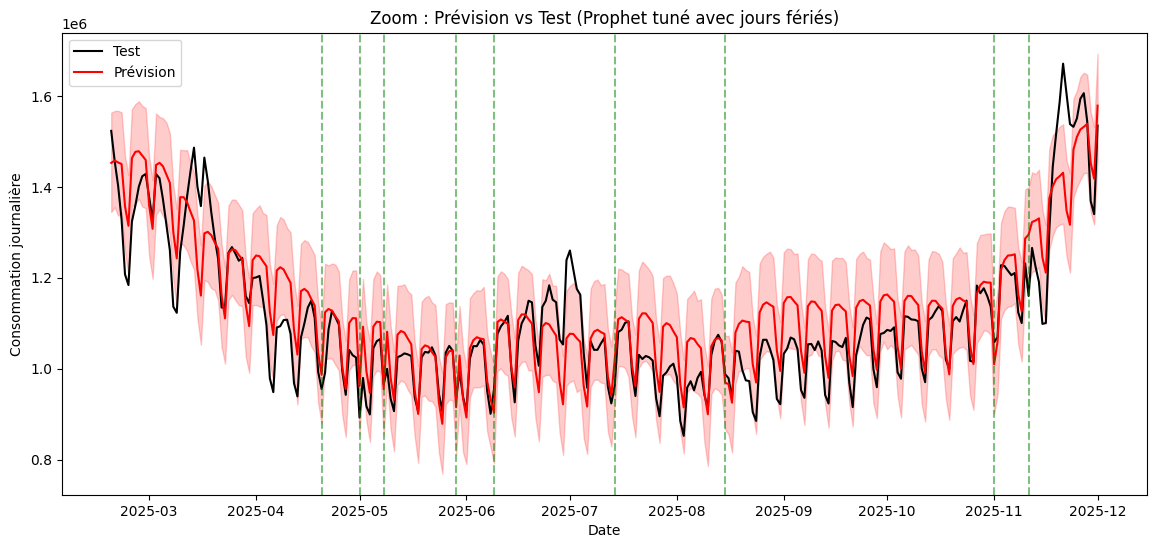

In [20]:
import matplotlib.pyplot as plt

# Zoom sur la période test
plt.figure(figsize=(14,6))

# Test réel
plt.plot(test['ds'], test['y'], label='Test', color='black')

# Prévision Prophet
plt.plot(forecast['ds'][-len(test):], forecast['yhat'][-len(test):], label='Prévision', color='red')

# Intervalle d'incertitude
plt.fill_between(forecast['ds'][-len(test):],
                 forecast['yhat_lower'][-len(test):],
                 forecast['yhat_upper'][-len(test):],
                 color='red', alpha=0.2)

# Jours fériés dans la période test
for d in holidays['ds']:
    if d >= test['ds'].min() and d <= test['ds'].max():
        plt.axvline(x=d, color='green', linestyle='--', alpha=0.5)

plt.legend()
plt.title("Zoom : Prévision vs Test (Prophet tuné avec jours fériés)")
plt.xlabel("Date")
plt.ylabel("Consommation journalière")
plt.show()

In [22]:
import pandas as pd
import numpy as np

# Extraire la période test
forecast_test = forecast[-len(test):][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
forecast_test['y'] = test['y'].values

# Calculer erreurs
forecast_test['abs_error'] = np.abs(forecast_test['y'] - forecast_test['yhat'])
forecast_test['error_pct'] = 100 * (forecast_test['yhat'] - forecast_test['y']) / forecast_test['y']

# Ajouter colonne jour férié
forecast_test['is_holiday'] = forecast_test['ds'].isin(holidays['ds'])

# Trier par erreur absolue décroissante pour voir les "pires jours"
forecast_test_sorted = forecast_test.sort_values(by='abs_error', ascending=False)

# Afficher top 10 jours avec la plus grosse erreur
forecast_test_sorted.head(50)

,ds,yhat,yhat_lower,yhat_upper,y,abs_error,error_pct,is_holiday
1421,2025-11-22,1.347963e+06,1.247361e+06,1.458682e+06,1604267,256303.764031,-15.976378,False
1420,2025-11-21,1.431248e+06,1.319361e+06,1.537916e+06,1671273,240024.766719,-14.361793,False
1422,2025-11-23,1.316717e+06,1.211275e+06,1.429886e+06,1538300,221582.931346,-14.404403,False
1170,2025-03-16,1.160878e+06,1.052765e+06,1.271600e+06,1357790,196911.899735,-14.502383,False
1277,2025-07-01,1.076884e+06,9.707841e+05,1.182083e+06,1260100,183215.567877,-14.539764,False
1169,2025-03-15,1.217590e+06,1.110838e+06,1.338489e+06,1400510,182920.415298,-13.060986,False
1276,2025-06-30,1.066717e+06,9.626090e+05,1.171801e+06,1238853,172135.717371,-13.894765,False
1171,2025-03-17,1.297817e+06,1.194685e+06,1.402645e+06,1464544,166727.178501,-11.384238,False
1162,2025-03-08,1.300707e+06,1.196661e+06,1.402638e+06,1136463,164244.161683,14.452223,False
1419,2025-11-20,1.423504e+06,1.316889e+06,1.532437e+06,1586853,163349.271932,-10.293913,False


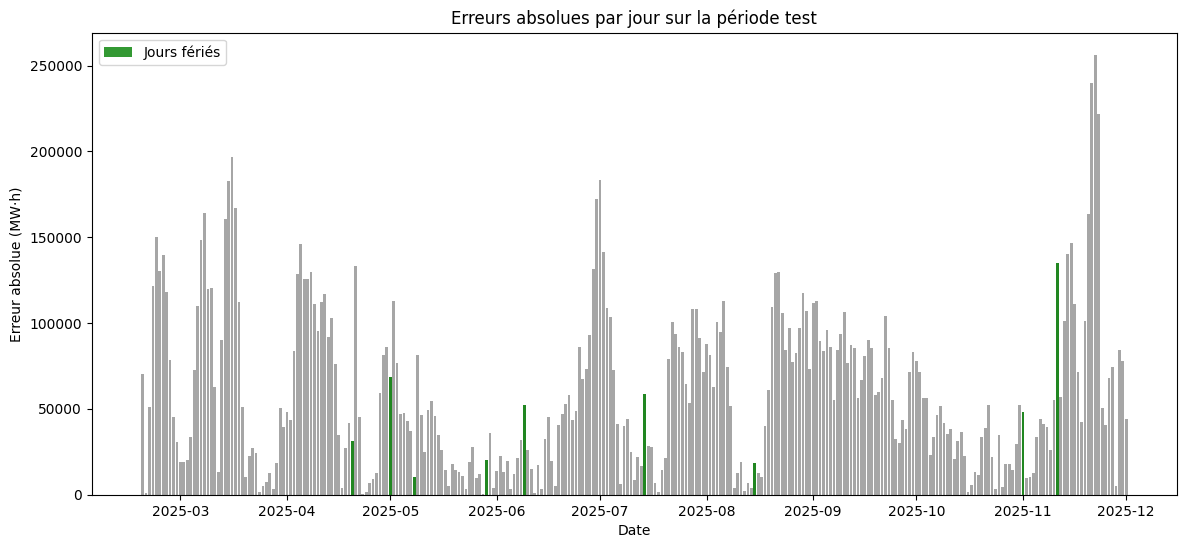

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.bar(forecast_test['ds'], forecast_test['abs_error'], color='gray', alpha=0.7)

# Jours fériés
plt.bar(forecast_test[forecast_test['is_holiday']]['ds'], 
        forecast_test[forecast_test['is_holiday']]['abs_error'], 
        color='green', alpha=0.8, label='Jours fériés')

plt.title("Erreurs absolues par jour sur la période test")
plt.xlabel("Date")
plt.ylabel("Erreur absolue (MW·h)")
plt.legend()
plt.show()
